In [1]:
import math
import random
import time

import sklearn.metrics
from numpy import arange, c_
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn import datasets

import scipy
from scipy import optimize

import numpy as np

from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve

import matplotlib.pyplot as plt

import pandas as pd

import seaborn as sns

sns.reset_orig()


noise = 16
samples = 2425
seed = 244825
classes = 2
train_split = 100
test_split = 0.2
repeats = 100

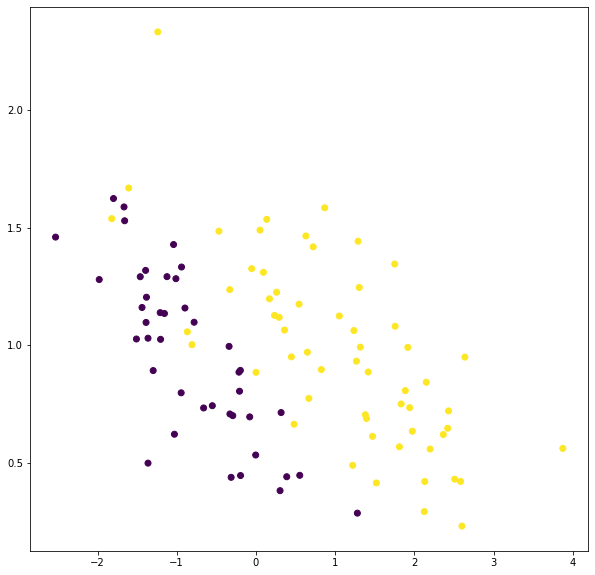

In [2]:
X, y = datasets.make_classification(n_features=2, random_state=seed, n_redundant=0, n_samples=samples, n_classes=2, n_clusters_per_class=1)

y[y == 0] = -1

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_split, test_size=test_split, random_state=seed)

xx, yy = np.meshgrid(np.arange(X.min(), X.max(), 0.01),
                       np.arange(X.min(), X.max(), 0.01))

plt.figure(figsize=(10,10))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

# moja implementacja

In [33]:
from scipy.optimize import LinearConstraint, Bounds, minimize


def linear_kernel(x1, x2, *args):
    return np.dot(x1, x2)


def poly_kernel(x1, x2, *args): # args[0] - degree, args[1] - gamma, args[2] - intercept
    return (args[1] * x1 @ x2.T + args[2]) ** args[0]
    # return (1 + x1 @ x2) ** args[0]


def rbf_kernel(x1, x2, *args):  # args[0] - degree, args[1] - gamma, args[2] - intercept
    return np.exp(-args[1] * np.linalg.norm(x1 - x2) ** 2)


def decision_function(x, w, b, linear, support_param=None, alpha_param=None, train_labels2=None, train_vector=None, kernel=None, degree=None, gamma=None):
    if linear:
        return np.dot(x, w) + b
    else:
        y_pred = []
        for sample in x:
            pred = 0
            for i in support_param:
                pred += alpha_param[i] * train_labels2[i] * kernel(sample, train_vector[i, :], degree, gamma, b)
            y_pred.append(pred)

        return np.array(y_pred)


def lagrange_function(alpha2, x, y2, kernel, degree, gamma):
    res = 0
    for i in range(alpha2.shape[0]):
        for j in range(alpha2.shape[0]):
            res += alpha2[i] * alpha2[j] * y2[i] * y2[j] * kernel(x[i], x[j], degree, gamma, 0)

    return  0.5 * res - sum(alpha2)


def fit(x_train, y_train2, kernel, degree=1, gamma=0.1, C=1.0):
    ZERO = 1e-5

    n, m = x_train.shape
    # np.random.seed(self.random_state)
    alpha_start = np.random.uniform(0, C, size=n)
    # alpha_start = np.zeros(n)
    linear_constraint = LinearConstraint(A=y_train2, lb=[0], ub=[0])
    bounds = Bounds(np.zeros(n), np.full(n, C-ZERO))
    result = minimize(
        fun=lagrange_function,
        x0=alpha_start,
        args=(x_train, y_train2, kernel, degree, gamma),
        # hess=BFGS(),
        constraints=[linear_constraint],
        bounds=bounds)
    alpha_ = result.x
    alpha_[alpha_ < ZERO] = 0
    support_ = np.where(alpha_ > ZERO)[0]
    support_vectors_ = x_train[support_]
    support_labels = y_train2[support_]
    train_vectors_ = x_train
    train_labels = y_train2

    coef_ = np.zeros(m)
    for i in support_:
        coef_ += alpha_[i] * y_train2[i] * x_train[i]

    intercept_ = 0
    # c_num = self.C - ZERO
    for i in support_:
        intercept_ += y_train2[i] - np.dot(coef_, x_train[i])
    intercept_ /= len(support_)
    print(coef_, intercept_)
    return coef_, intercept_, support_vectors_, support_, alpha_, train_labels, train_vectors_



def predict(x, w, b, linear, support_param=None, alpha_param=None, train_labels=None, train_vector=None, kernel=None, degree=None, gamma=None):
    return np.sign(decision_function(x, w, b, linear, support_param, alpha_param, train_labels, train_vector, kernel, degree, gamma))

### linear

In [5]:
theta, bias, support_v, support, alpha, train_label, train_vectors = fit(X_train, y_train, kernel=linear_kernel, degree=1, gamma=0.1, C=1.0)

[1.74520982 2.73619101] -2.3796938250558632


In [6]:
predict_var = predict(X_test, theta, bias, linear=True)

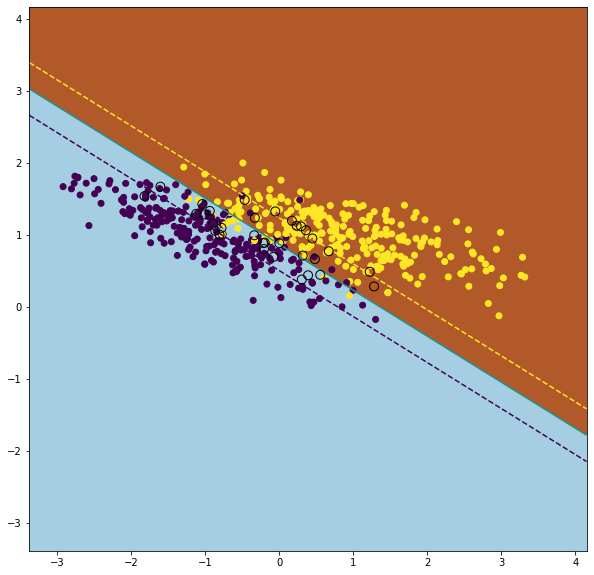

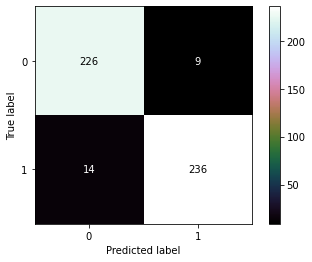

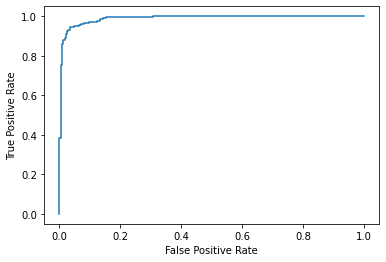

In [7]:
mesh_data = c_[xx.ravel(), yy.ravel()]


predict_cntr = predict(mesh_data, theta, bias, True)
predict_cntr = predict_cntr.reshape(xx.shape)

Z = decision_function(mesh_data, theta, bias, True).reshape(xx.shape)

plt.figure(figsize=(10, 10))
plt.pcolormesh(xx, yy, Z > 0, cmap=plt.cm.Paired)
plt.contour(xx, yy, Z, linestyles=["--", "-", "--"], levels=[-1, 0, 1])
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
plt.scatter(support_v[:, 0], support_v[:, 1], s=80, facecolors='none', zorder=10, edgecolors='k')

cm_model = confusion_matrix(y_test, predict_var, labels=[-1, 1])
tn_model = cm_model[0][0]
fn_model = cm_model[0][1]
tp_model = cm_model[1][1]
fp_model = cm_model[1][0]
ConfusionMatrixDisplay(cm_model).plot(cmap='cubehelix')

fpr, tpr, roc_auc = roc_curve(y_test, decision_function(X_test, theta, bias, True))

rok_model = RocCurveDisplay(fpr=fpr, tpr=tpr)
rok_model.plot()

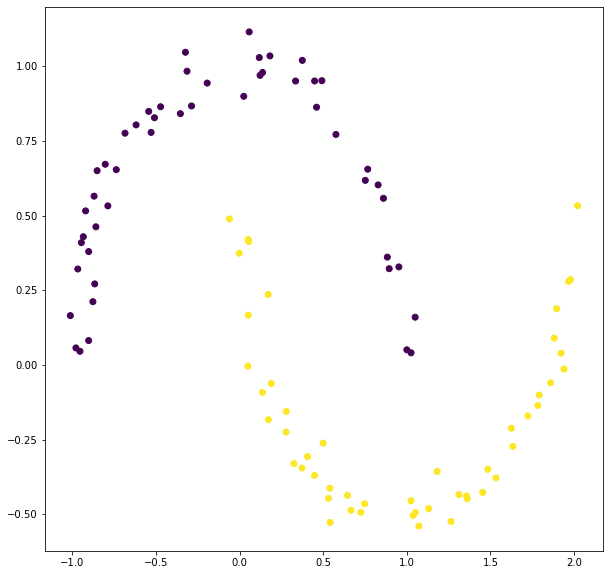

In [27]:
# X, y = datasets.make_classification(n_features=2, random_state=seed, n_redundant=0, n_samples=samples, n_classes=2, n_clusters_per_class=1)
X, y = datasets.make_moons(random_state=seed, n_samples=samples, noise=0.05)

y[y == 0] = -1

poly = PolynomialFeatures(degree=4, include_bias=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_split, test_size=test_split, random_state=seed, shuffle=True, stratify=y)

xx, yy = np.meshgrid(np.arange(X.min(), X.max(), 0.01),
                       np.arange(X.min(), X.max(), 0.01))

# X_train = my_normalize(X_train)
# X_test = my_normalize(X_test)
# X_train = poly.fit_transform(X_train)
# X_test = poly.fit_transform(X_test)


plt.figure(figsize=(10,10))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

### poly

In [34]:
theta, bias, support_v, support, alpha, train_labels, train_vectors = fit(X_train, y_train, degree=3, kernel=poly_kernel, gamma=0.75, C=1.0)

[ 1.65376886 -8.08261614] 1.1960874595574995


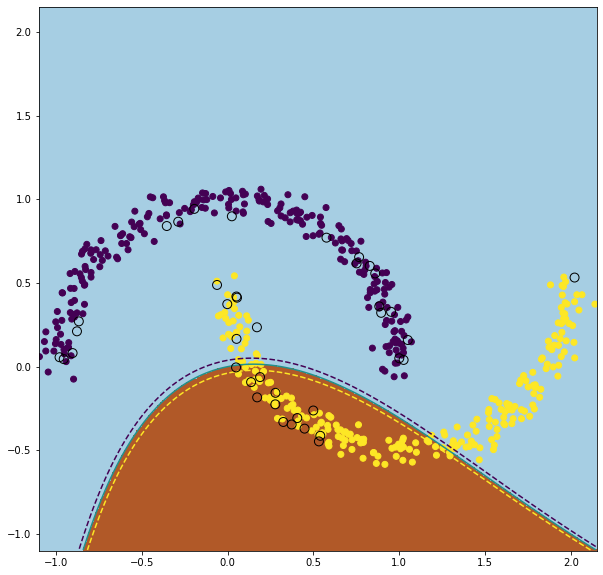

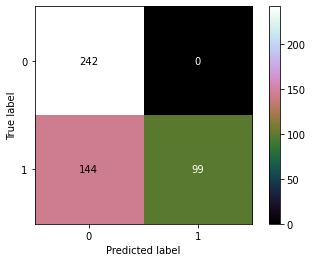

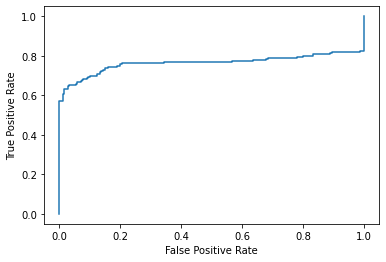

In [32]:
predict_var = predict(X_test, theta, bias, False, support, alpha, train_labels, train_vectors, poly_kernel, 3, 0.75)
mesh_data = c_[xx.ravel(), yy.ravel()]

# mesh_data = poly.fit_transform(mesh_data)


predict_cntr = predict(mesh_data, theta, bias, False, support, alpha, train_labels, train_vectors, poly_kernel, 3, 0.75)
predict_cntr = predict_cntr.reshape(xx.shape)

Z = decision_function(mesh_data, theta, bias, False, support, alpha, train_labels, train_vectors, poly_kernel, 3, 0.75).reshape(xx.shape)

plt.figure(figsize=(10, 10))
plt.pcolormesh(xx, yy, Z > 0, cmap=plt.cm.Paired)
plt.contour(xx, yy, Z, linestyles=["--", "-", "--"], levels=[-1, 0, 1])
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
plt.scatter(support_v[:, 0], support_v[:, 1], s=80, facecolors='none', zorder=10, edgecolors='k')

cm_model = confusion_matrix(y_test, predict_var, labels=[-1, 1])
tn_model = cm_model[0][0]
fn_model = cm_model[0][1]
tp_model = cm_model[1][1]
fp_model = cm_model[1][0]
ConfusionMatrixDisplay(cm_model).plot(cmap='cubehelix')

fpr, tpr, roc_auc = roc_curve(y_test, decision_function(X_test, theta, bias, False, support, alpha, train_labels, train_vectors, poly_kernel, 3, 0.75))

rok_model = RocCurveDisplay(fpr=fpr, tpr=tpr)
rok_model.plot()

### rbf

In [11]:
theta, bias, support_v, support, alpha, train_labels, train_vectors = fit(X_train, y_train, kernel=rbf_kernel, gamma=0.75, C=1.0)

[ 5.07042103 -2.9863926 ] -1.631356541158614


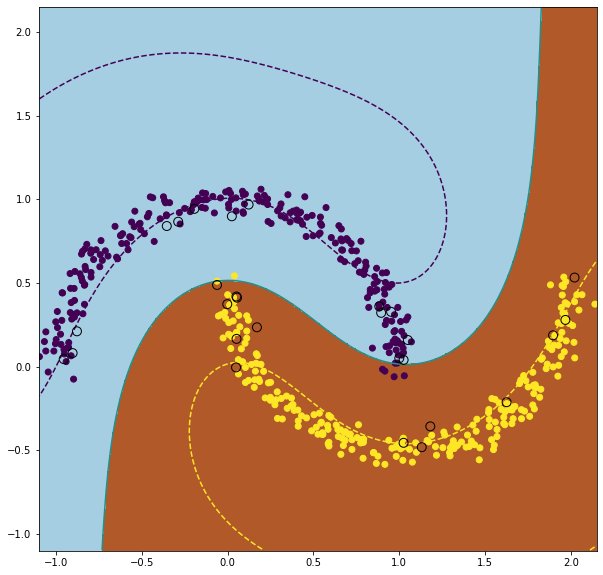

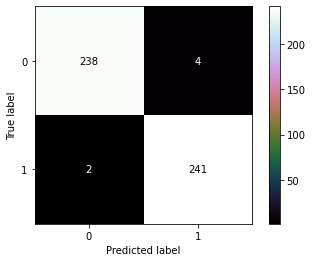

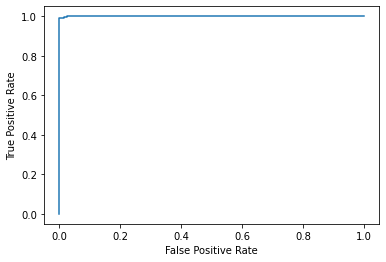

In [12]:
predict_var = predict(X_test, theta, bias, False, support, alpha, train_labels, train_vectors, rbf_kernel, 1, 0.75)
mesh_data = c_[xx.ravel(), yy.ravel()]

# mesh_data = poly.fit_transform(mesh_data)


predict_cntr = predict(mesh_data, theta, bias, False, support, alpha, train_labels, train_vectors, rbf_kernel, 1, 0.75)
predict_cntr = predict_cntr.reshape(xx.shape)

Z = decision_function(mesh_data, theta, bias, False, support, alpha, train_labels, train_vectors, rbf_kernel, 1, 0.75).reshape(xx.shape)

plt.figure(figsize=(10, 10))
plt.pcolormesh(xx, yy, Z > 0, cmap=plt.cm.Paired)
plt.contour(xx, yy, Z, linestyles=["--", "-", "--"], levels=[-1, 0, 1])
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
plt.scatter(support_v[:, 0], support_v[:, 1], s=80, facecolors='none', zorder=10, edgecolors='k')

cm_model = confusion_matrix(y_test, predict_var, labels=[-1, 1])
tn_model = cm_model[0][0]
fn_model = cm_model[0][1]
tp_model = cm_model[1][1]
fp_model = cm_model[1][0]
ConfusionMatrixDisplay(cm_model).plot(cmap='cubehelix')

fpr, tpr, roc_auc = roc_curve(y_test, decision_function(X_test, theta, bias, False, support, alpha, train_labels, train_vectors, rbf_kernel, 1, 0.75))

rok_model = RocCurveDisplay(fpr=fpr, tpr=tpr)
rok_model.plot()

# SKLEARN

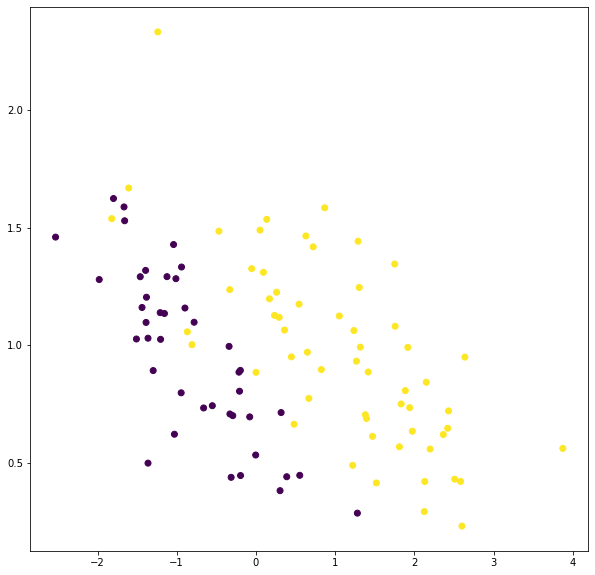

In [20]:
X, y = datasets.make_classification(n_features=2, random_state=seed, n_redundant=0, n_samples=samples, n_classes=2, n_clusters_per_class=1)

y[y == 0] = -1

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_split, test_size=test_split, random_state=seed)

xx, yy = np.meshgrid(np.arange(X.min(), X.max(), 0.01),
                       np.arange(X.min(), X.max(), 0.01))

plt.figure(figsize=(10,10))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

### Linear

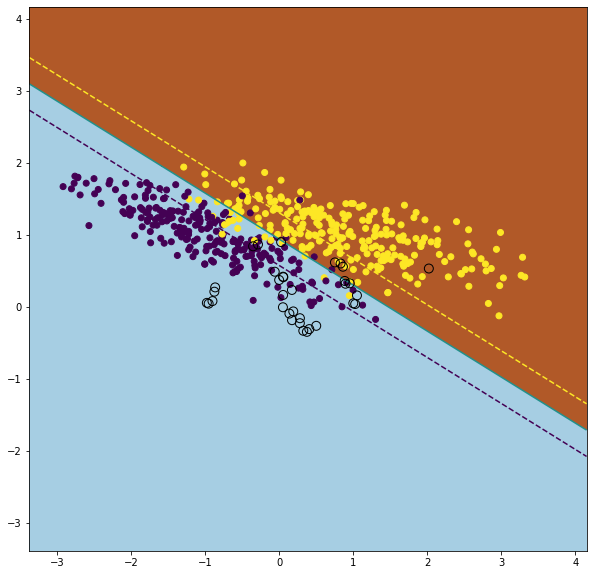

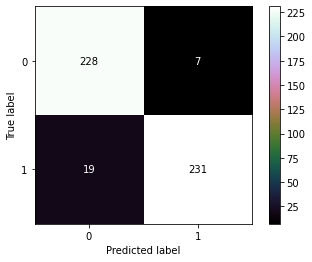

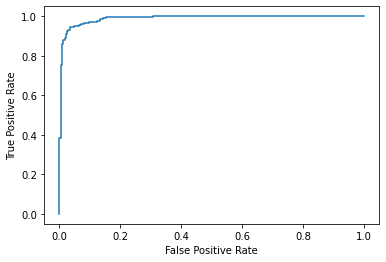

In [23]:
model = SVC(kernel='linear', gamma=0.1, degree=1, random_state=seed, C=1)

model.fit(X_train, y_train)

prd = model.predict(X_test)

mesh_data = c_[xx.ravel(), yy.ravel()]

predict_cntr = model.predict(mesh_data)
predict_cntr = predict_cntr.reshape(xx.shape)

Z = model.decision_function(mesh_data).reshape(xx.shape)

plt.figure(figsize=(10, 10))
plt.pcolormesh(xx, yy, Z > 0, cmap=plt.cm.Paired)
plt.contour(xx, yy, Z, linestyles=["--", "-", "--"], levels=[-1, 0, 1])
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
plt.scatter(support_v[:, 0], support_v[:, 1], s=80, facecolors='none', zorder=10, edgecolors='k')

cm_model = confusion_matrix(y_test, prd, labels=[-1, 1])
tn_model = cm_model[0][0]
fn_model = cm_model[0][1]
tp_model = cm_model[1][1]
fp_model = cm_model[1][0]
ConfusionMatrixDisplay(cm_model).plot(cmap='cubehelix')

fpr, tpr, roc_auc = roc_curve(y_test, model.decision_function(X_test))

rok_model = RocCurveDisplay(fpr=fpr, tpr=tpr)
rok_model.plot()

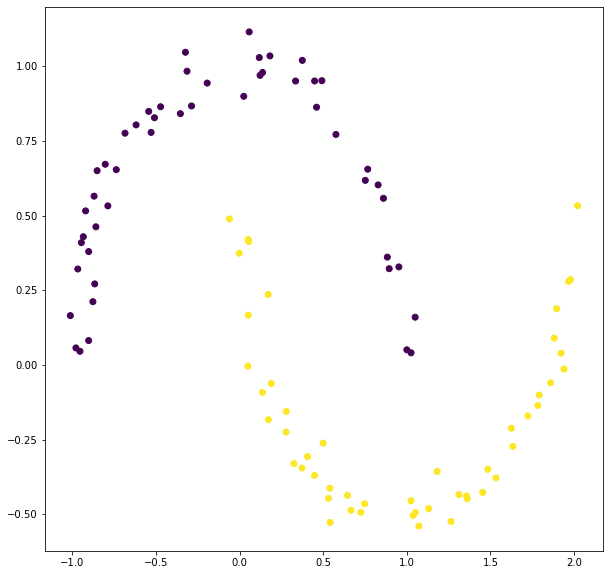

In [24]:
# X, y = datasets.make_classification(n_features=2, random_state=seed, n_redundant=0, n_samples=samples, n_classes=2, n_clusters_per_class=1)
X, y = datasets.make_moons(random_state=seed, n_samples=samples, noise=0.05)

y[y == 0] = -1

poly = PolynomialFeatures(degree=4, include_bias=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_split, test_size=test_split, random_state=seed, shuffle=True, stratify=y)

xx, yy = np.meshgrid(np.arange(X.min(), X.max(), 0.01),
                       np.arange(X.min(), X.max(), 0.01))

# X_train = my_normalize(X_train)
# X_test = my_normalize(X_test)
# X_train = poly.fit_transform(X_train)
# X_test = poly.fit_transform(X_test)


plt.figure(figsize=(10,10))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

### Poly

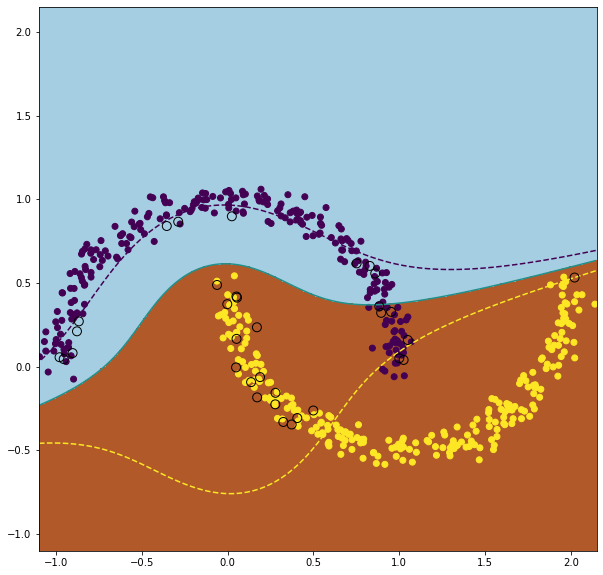

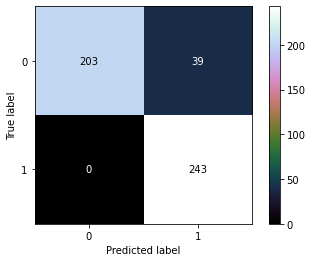

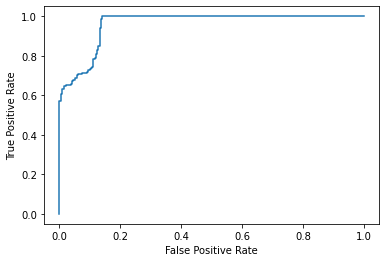

In [25]:
model = SVC(kernel='poly', gamma=0.75, degree=3, random_state=seed, C=1)

model.fit(X_train, y_train)

prd = model.predict(X_test)

mesh_data = c_[xx.ravel(), yy.ravel()]

predict_cntr = model.predict(mesh_data)
predict_cntr = predict_cntr.reshape(xx.shape)

Z = model.decision_function(mesh_data).reshape(xx.shape)

plt.figure(figsize=(10, 10))
plt.pcolormesh(xx, yy, Z > 0, cmap=plt.cm.Paired)
plt.contour(xx, yy, Z, linestyles=["--", "-", "--"], levels=[-1, 0, 1])
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
plt.scatter(support_v[:, 0], support_v[:, 1], s=80, facecolors='none', zorder=10, edgecolors='k')

cm_model = confusion_matrix(y_test, prd, labels=[-1, 1])
tn_model = cm_model[0][0]
fn_model = cm_model[0][1]
tp_model = cm_model[1][1]
fp_model = cm_model[1][0]
ConfusionMatrixDisplay(cm_model).plot(cmap='cubehelix')

fpr, tpr, roc_auc = roc_curve(y_test, model.decision_function(X_test))

rok_model = RocCurveDisplay(fpr=fpr, tpr=tpr)
rok_model.plot()

In [ ]:
model = SVC(kernel='rbf', gamma=0.75, degree=3, random_state=seed, C=1)

model.fit(X_train, y_train)

prd = model.predict(X_test)

mesh_data = c_[xx.ravel(), yy.ravel()]

predict_cntr = model.predict(mesh_data)
predict_cntr = predict_cntr.reshape(xx.shape)

Z = model.decision_function(mesh_data).reshape(xx.shape)

plt.figure(figsize=(10, 10))
plt.pcolormesh(xx, yy, Z > 0, cmap=plt.cm.Paired)
plt.contour(xx, yy, Z, linestyles=["--", "-", "--"], levels=[-1, 0, 1])
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
plt.scatter(support_v[:, 0], support_v[:, 1], s=80, facecolors='none', zorder=10, edgecolors='k')

cm_model = confusion_matrix(y_test, prd, labels=[-1, 1])
tn_model = cm_model[0][0]
fn_model = cm_model[0][1]
tp_model = cm_model[1][1]
fp_model = cm_model[1][0]
ConfusionMatrixDisplay(cm_model).plot(cmap='cubehelix')

fpr, tpr, roc_auc = roc_curve(y_test, model.decision_function(X_test))

rok_model = RocCurveDisplay(fpr=fpr, tpr=tpr)
rok_model.plot()

# Cz 3

In [37]:
data = pd.read_csv('star_classification_SDSS17.csv')
data

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.237679e+18,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,7778,301,2,581,1.055431e+19,GALAXY,0.000000,9374,57749,438
99996,1.237679e+18,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,7917,301,1,289,8.586351e+18,GALAXY,0.404895,7626,56934,866
99997,1.237668e+18,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,5314,301,4,308,3.112008e+18,GALAXY,0.143366,2764,54535,74
99998,1.237661e+18,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,3650,301,4,131,7.601080e+18,GALAXY,0.455040,6751,56368,470
